In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
import seaborn as sns

pd.set_option('display.max_columns', None)


import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')

## Load Data

In [51]:
# windows
df1 = pd.read_csv('/Users/chloe.song/Documents/Projects/DS191/11FinTech/data/loan_2014.csv')

# mac
# df1 = pd.read_csv('loan_2014.csv')

C:\Users\chloe.song\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [52]:
df1.shape

(235631, 103)

In [10]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235631 entries, 0 to 235630
Columns: 103 entries, addrstate to loanstatus
dtypes: float64(85), object(18)
memory usage: 185.2+ MB


## Select Data

In [53]:
all_null_feature =['inqlast12m',
 'verificationstatusjoint',
 'maxbalbc',
 'annualincjoint',
 'memberid',
 'openil6m',
 'openacc6m',
 'totalbalil',
 'inqfi',
 'mthssincercntil',
 'openrv24m',
 'openrv12m',
 'dtijoint',
 'openil12m',
 'openil24m',
 'allutil',
 'totalcutl',
 'ilutil']

In [54]:
ob_feature=['id',
 'zipcode',
 'revolutil',
 'intrate',
 'applicationtype',
 'grade',
 'term',
 'subgrade',
 'earliestcrline',
 'initialliststatus',
 'purpose',
 'emptitle',
 'verificationstatus',
 'addrstate',
 'homeownership',
 'emplength',
 'issued',
 'loanstatus']

In [55]:
num_feature=['avgcurbal',
 'numrevaccts',
 'mortacc',
 'numactvrevtl',
 'totalilhighcreditlimit',
 'numiltl',
 'mthssincelastdelinq',
 'totalacc',
 'revolbal',
 'numacctsever120pd',
 'pcttlnvrdlq',
 'numtl30dpd',
 'percentbcgt75',
 'numoprevtl',
 'bcutil',
 'numactvbctl',
 'bcopentobuy',
 'totalrevhilim',
 'numrevtlbalgt0',
 'mthssincerecentrevoldelinq',
 'tothicredlim',
 'fundedamnt',
 'numtl90gdpd24m',
 'mthssincerecentinq',
 'numbcsats',
 'installment',
 'totalbclimit',
 'mosinoldrevtlop',
 'numsats',
 'inqlast6mths',
 'mthssincerecentbc',
 'mosinrcnttl',
 'loanamnt',
 'mthssincerecentbcdlq',
 'totalbalexmort',
 'numbctl',
 'openacc',
 'dti',
 'totcollamt',
 'numtloppast12m',
 'annualinc',
 'totcurbal',
 'accnowdelinq',
 'pubrecbankruptcies',
 'chargeoffwithin12mths',
 'collections12mthsexmed',
 'numtl120dpd2m',
 'accopenpast24mths',
 'mthssincelastrecord',
 'taxliens',
 'mosinoldilacct',
 'delinq2yrs',
 'mosinrcntrevtlop',
 'pubrec',
 'delinqamnt',
 'mthssincelastmajorderog']

In [56]:
select_feature = ob_feature + num_feature
len(select_feature)

74

In [57]:
# remove applicationtype since it only has one value as 'individual'

ob_feature.remove('applicationtype')


In [58]:
# remove fundedamnt since it always equals to 1 for issued loans and varied during different time of a current loan

num_feature.remove('fundedamnt')


In [59]:
# remove 'id','issued' and 'loanstatus' from ob_feature, since they are index, train/test flag and target
ob_feature.remove('id')
ob_feature.remove('loanstatus')
ob_feature.remove('issued')


In [12]:
# remove 'desc' from ob_feature and select_feature
#ob_feature.remove('desc')


In [60]:
select_feature = ob_feature + num_feature
len(select_feature)

69

In [61]:
# selected features left and delete the last two rows
df = df1[select_feature + ['id','loanstatus','issued']][:-2]

In [62]:
df.shape

(235629, 72)

## only use term=36 months and loanstatus = fully paid and charged off

In [63]:
df = df.query("loanstatus == 'Fully Paid' or loanstatus == 'Charged Off' ")

In [64]:
df = df.query("term ==' 36 months'")

In [66]:
df.shape

(162570, 72)

In [67]:
df.drop('term', axis = 1, inplace=True)

In [68]:
df.shape

(162570, 71)

In [69]:
ob_feature.remove('term')

## Label Target
Fully Paid (No default): 0 付清 <br>
Charged Off (Default): 1 坏账


In [70]:
df['loanstatus'] = df.loanstatus.map({"Charged Off": 1, "Fully Paid": 0})

In [71]:
print (df.loanstatus.value_counts())
print (df.loanstatus.value_counts(normalize=True))

0    140255
1     22315
Name: loanstatus, dtype: int64
0    0.862736
1    0.137264
Name: loanstatus, dtype: float64


## Out of time testing set and in-time training set: Oct~Dec as test)

In [72]:
issued=list(df['issued'].unique())
issued

['Dec-2014',
 'Nov-2014',
 'Oct-2014',
 'Sep-2014',
 'Aug-2014',
 'Jul-2014',
 'Jun-2014',
 'May-2014',
 'Apr-2014',
 'Mar-2014',
 'Feb-2014',
 'Jan-2014']

In [73]:
df['train_flg'] = df.issued.apply(lambda x: 0 if x in issued[:3] else 1)
df.train_flg.value_counts()

1    112550
0     50020
Name: train_flg, dtype: int64

In [74]:
df.drop('issued', axis = 1, inplace=True)

In [75]:
df.shape

(162570, 71)

## Feature Engineering & Cleaning

#### Datetime to numeric feature

In [76]:
# earliestcrlin： 最早有信用的时间
df.earliestcrline.unique()[:5]

array(['Sep-1989', 'Nov-1992', 'Aug-2002', 'Jan-2001', 'Oct-1998'],
      dtype=object)

In [29]:
# convert to number of months to Dec 2014

In [77]:
cl_month = df.earliestcrline.apply(lambda x: x.split('-')[0])
cl_year = df.earliestcrline.apply(lambda x: int(x.split('-')[1]))

In [78]:
cl_month.unique()

array(['Sep', 'Nov', 'Aug', 'Jan', 'Oct', 'May', 'Jul', 'Dec', 'Jun',
       'Mar', 'Feb', 'Apr'], dtype=object)

In [79]:
cl_year.unique()

array([1989, 1992, 2002, 2001, 1998, 1999, 2009, 2003, 1993, 1995, 1996,
       2010, 2006, 2007, 1997, 2004, 1984, 2008, 2011, 2000, 1988, 1994,
       1987, 1985, 2005, 1991, 1986, 1973, 1982, 1979, 1974, 1976, 1983,
       1981, 1990, 1978, 1980, 1977, 1969, 1971, 1967, 1972, 1968, 1962,
       1975, 1965, 1966, 1963, 1970, 1964, 1958, 1955, 1959, 1961, 1960,
       1954, 1957, 1949, 1950, 1948, 1953, 1956], dtype=int64)

In [80]:
dic_month= {'Jan':11,'Feb':10,'Mar':9,'Apr':8, 'May':7, 'Jun':6, 'Jul':5, 'Aug':4, 'Sep':3, 'Oct':2, 'Nov':1, 'Dec':0}



In [81]:
# 到2014年12月为止，具有信用历史几个月了 2014-1989*12+(12-9)
df['earliestcrline_month'] = df.earliestcrline.apply(
            lambda x: (2014 - int(x.split('-')[1]))*12 + dic_month[x.split('-')[0]] )


In [82]:
df.earliestcrline[:5]

0    Sep-1989
2    Nov-1992
3    Aug-2002
6    Jan-2001
7    Oct-1998
Name: earliestcrline, dtype: object

In [83]:
df.earliestcrline_month[:5]

0    303
2    265
3    148
6    167
7    194
Name: earliestcrline_month, dtype: int64

In [84]:
num_feature.append('earliestcrline_month')
ob_feature.remove('earliestcrline')


In [85]:
print (len(ob_feature), len(num_feature))

12 56


In [86]:
df.drop('earliestcrline', axis = 1, inplace=True)

In [87]:
df.shape

(162570, 71)

### emplength to numeric feature

In [88]:
print (df['emplength'].isnull().sum())
df['emplength'].unique()

9646


array(['8 years', '10+ years', '< 1 year', '2 years', '7 years',
       '9 years', nan, '5 years', '4 years', '3 years', '1 year',
       '6 years'], dtype=object)

In [89]:
df['emplength'].replace('n/a', np.nan, inplace=True) # na - no content，default no job
df['emplength'].replace('< 1 year', '0', inplace=True)
df['emplength'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
df.emplength.fillna(value=-999, inplace=True) # -999想表示空值是一个不好的事情，留空在xgboost也可以
df['emplength'] = df['emplength'].astype(int)

df['emplength'].unique()

array([   8,   10,    0,    2,    7,    9, -999,    5,    4,    3,    1,
          6], dtype=int64)

In [90]:
df.emplength.value_counts()

 10     51146
 2      14669
 3      13106
 0      13056
 1      10571
 4       9670
-999     9646
 5       9148
 7       8946
 6       8205
 8       8131
 9       6276
Name: emplength, dtype: int64

In [91]:
num_feature.append('emplength')
ob_feature.remove('emplength')
print (len(num_feature), len(ob_feature))

57 11


In [92]:
df.shape

(162570, 71)

## % to numeric feature: intrate, revolutil

In [93]:
intrate = df.intrate.apply(lambda x: float(x.replace('%','')))

In [94]:
df.intrate = intrate
df.intrate[:2]

0     6.99
2    13.66
Name: intrate, dtype: float64

In [95]:
df.revolutil = pd.Series(df.revolutil).str.replace('%', '').astype(float)

In [96]:
df.revolutil[:2]

0    31.6
2    59.4
Name: revolutil, dtype: float64

In [97]:
ob_feature.remove('intrate')
num_feature.append('intrate')
ob_feature.remove('revolutil')
num_feature.append('revolutil')

In [98]:
print (len(ob_feature), len(num_feature))

9 59


#### Ordinal feature encoding : grade, subgrade

In [99]:
Dic_grade = {"A": 1, 
            "B": 2, 
            "C": 3, 
            "D": 4, 
            "E": 5,
            "F": 6, 
            "G": 7}

In [100]:
df.grade = df.grade.map(Dic_grade)

In [101]:
df.subgrade = df.subgrade.apply(lambda x: (Dic_grade[x[0]] - 1) * 5 + int(x[1]))

In [102]:
ob_feature.remove('grade')
num_feature.append('grade')
ob_feature.remove('subgrade')
num_feature.append('subgrade')

In [103]:
print (len(ob_feature), len(num_feature))

7 61


### High cardinality feature encoding

###### Zip Code - frequency encoding 

In [104]:
print (df.zipcode.nunique(), df.zipcode.unique()[:5])

854 ['937xx' '077xx' '850xx' '144xx' '982xx']


In [105]:
df.zipcode = df.zipcode.apply(lambda x: int(x[0:3]))

In [106]:
# 每一个zipcode出现的次数
zipcode_freq = df.groupby("zipcode").size().reset_index() 

In [107]:
zipcode_freq[:5]

,zipcode,0
0,8,1
1,10,229
2,11,66
3,12,69
4,13,41


In [108]:
zipcode_freq.columns = ["zipcode", "zipcode_freq"]

In [109]:
df = pd.merge(df, zipcode_freq, how = "left", on = "zipcode")

In [110]:
ob_feature.remove('zipcode')
num_feature.append('zipcode_freq')
num_feature.append('zipcode')
print (len(ob_feature), len(num_feature))

6 63


### emptitle-frequency encoding (can do some NLP for later stage)

In [111]:

emptitle_freq = df.groupby("emptitle").size().reset_index()
emptitle_freq.columns = ["emptitle", "emptitle_freq"]
df = pd.merge(df, emptitle_freq, how = "left", on = "emptitle")


In [112]:
df.drop("emptitle", axis = 1, inplace=True)

In [113]:
ob_feature.remove('emptitle')
num_feature.append('emptitle_freq')
print (len(ob_feature), len(num_feature))

5 64


###### Addr_state - frequency encoding

In [114]:
addrstate_freq = df.groupby("addrstate").size().reset_index()
addrstate_freq.columns = ["addrstate", "addrstate_freq"]
df = pd.merge(df, addrstate_freq, how = "left", on = "addrstate")


In [115]:
df.drop("addrstate", axis = 1, inplace=True)

In [116]:
ob_feature.remove('addrstate')
num_feature.append('addrestate_freq')
print (len(ob_feature), len(num_feature))

4 65


#### One hot encoding

In [117]:

dummy_feature = ["homeownership", "verificationstatus", "purpose", "initialliststatus"]

In [118]:
df_dummy = pd.get_dummies(df[dummy_feature])


In [119]:
df_dummy.shape

(162570, 22)

In [120]:
df = pd.concat([df,df_dummy], axis=1 )

In [121]:
df.shape

(162570, 94)

In [122]:
df.drop(dummy_feature, axis = 1, inplace=True)

In [123]:
df.shape

(162570, 90)

## Feature Explore and Visualization

### dti - Debt Income Ratio
A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.每个月要付的债务额与每个月的税前收入的比例 <br>
dti越高越容易坏帐

In [235]:
df['bin_dti'] = pd.cut(df.dti, bins=5,precision=0) #precision : bins小数精度，也就是数据以几位小数显示
df['bin_dti'].unique()

[(8.0, 16.0], (24.0, 32.0], (32.0, 40.0], (16.0, 24.0], (-0.0, 8.0]]
Categories (5, interval[float64]): [(-0.0, 8.0] < (8.0, 16.0] < (16.0, 24.0] < (24.0, 32.0] < (32.0, 40.0]]

In [ ]:
sns.set_style('whitegrid')

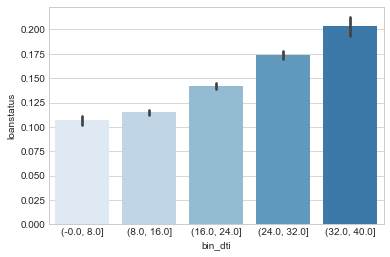

In [209]:
sns.barplot(x='bin_dti',
           y ='loanstatus',
           data=df,
           palette=sns.color_palette('Blues'))

### grade and subgrade

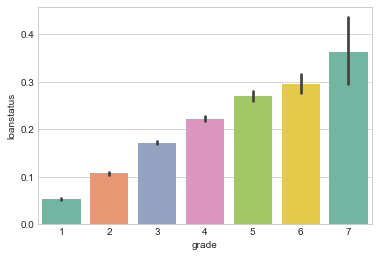

In [211]:
sns.barplot(x='grade',
            y ='loanstatus',
           data = df,
           palette = sns.color_palette('Set2'))

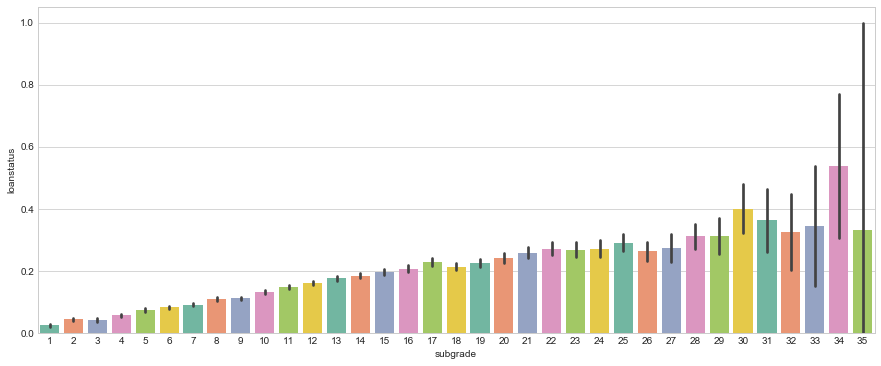

In [216]:
plt.figure(figsize=(15,6))
sns.barplot(x='subgrade',
            y ='loanstatus',
           data = df,
           palette = sns.color_palette('Set2'))

### Installment
The monthly payment owed by the borrower if the loan originates.

In [218]:
df['bin_installment'] = pd.cut(df.installment,bins=5,precision=2)


(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

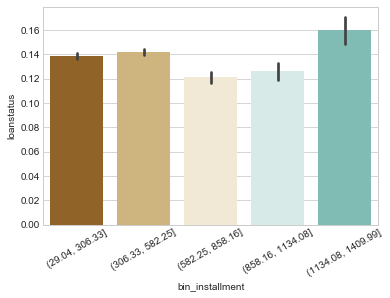

In [221]:
sns.barplot(x='bin_installment',
           y='loanstatus',
            data=df,
           palette = sns.color_palette('BrBG'))
plt.xticks(rotation=30)

### annualinc - Annual income
The self-reported annual income provided by the borrower during registration <br>
收入越低越容易坏帐

In [223]:
print(min(df.annualinc),max(df.annualinc))
df['bin_annualinc'] = pd.cut(df.annualinc, bins=[0, 25000, 50000, 75000, 100000, 125000, 150000, \
                                                 175000, 200000, max(df.annualinc)], precision=0)

3000.0 7500000.0


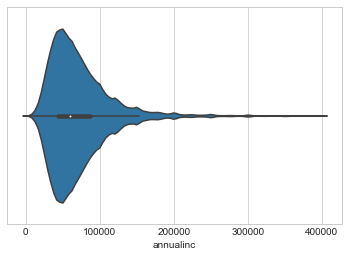

In [226]:
sns.violinplot(x='annualinc',
              data=df[df['annualinc'] <400000]
              )

[Text(0,0,'<25k'),
 Text(0,0,'25-50k'),
 Text(0,0,'50-75k'),
 Text(0,0,'75-100k'),
 Text(0,0,'100-125k'),
 Text(0,0,'125-150k'),
 Text(0,0,'150-175k'),
 Text(0,0,'175-200k'),
 Text(0,0,'>200k')]

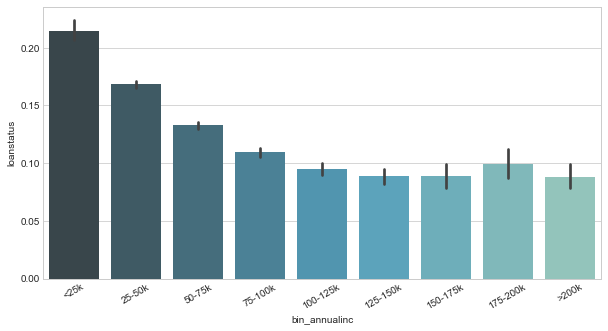

In [233]:
plt.figure(figsize=(10,5))
fig = sns.barplot(x='bin_annualinc', y= 'loanstatus', data = df, palette=sns.color_palette("GnBu_d", 10))

fig.set_xticklabels(labels=['<25k', '25-50k', '50-75k', '75-100k', '100-125k', '125-150k',\
                            '150-175k', '175-200k', '>200k'], rotation = 30)

### Intrate - Interest Rate
利率越高越容易坏帐

In [234]:
df['bin_intrate'] = pd.cut(df.intrate, bins=5, precision=2)

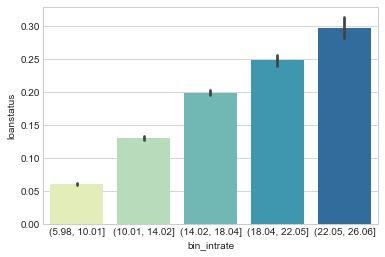

In [236]:
sns.barplot(x='bin_intrate',
            y= 'loanstatus', 
            data = df, 
            palette=sns.color_palette("YlGnBu")
           )

In [240]:
min(df.accopenpast24mths)

0.0

### accopenpast24mths
number of accounts opened in past 24 months

In [243]:
df['bin_accopenpast24mths'] = pd.cut(df.accopenpast24mths, bins=5, precision=0)
df['bin_accopenpast24mths'].unique()

[(-0.1, 11.0], (11.0, 21.0], (21.0, 32.0], (32.0, 42.0], (42.0, 53.0]]
Categories (5, interval[float64]): [(-0.1, 11.0] < (11.0, 21.0] < (21.0, 32.0] < (32.0, 42.0] < (42.0, 53.0]]

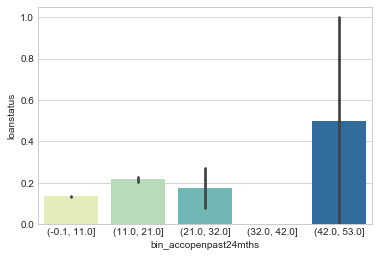

In [244]:
sns.barplot(x='bin_accopenpast24mths',
            y= 'loanstatus', 
            data = df, 
            palette=sns.color_palette("YlGnBu")
           )

##  Train Model


In [124]:
feat = list(df.columns.values)
print (feat)

['zipcode', 'revolutil', 'intrate', 'grade', 'subgrade', 'emplength', 'avgcurbal', 'numrevaccts', 'mortacc', 'numactvrevtl', 'totalilhighcreditlimit', 'numiltl', 'mthssincelastdelinq', 'totalacc', 'revolbal', 'numacctsever120pd', 'pcttlnvrdlq', 'numtl30dpd', 'percentbcgt75', 'numoprevtl', 'bcutil', 'numactvbctl', 'bcopentobuy', 'totalrevhilim', 'numrevtlbalgt0', 'mthssincerecentrevoldelinq', 'tothicredlim', 'numtl90gdpd24m', 'mthssincerecentinq', 'numbcsats', 'installment', 'totalbclimit', 'mosinoldrevtlop', 'numsats', 'inqlast6mths', 'mthssincerecentbc', 'mosinrcnttl', 'loanamnt', 'mthssincerecentbcdlq', 'totalbalexmort', 'numbctl', 'openacc', 'dti', 'totcollamt', 'numtloppast12m', 'annualinc', 'totcurbal', 'accnowdelinq', 'pubrecbankruptcies', 'chargeoffwithin12mths', 'collections12mthsexmed', 'numtl120dpd2m', 'accopenpast24mths', 'mthssincelastrecord', 'taxliens', 'mosinoldilacct', 'delinq2yrs', 'mosinrcntrevtlop', 'pubrec', 'delinqamnt', 'mthssincelastmajorderog', 'id', 'loanstatus

In [125]:
feat.remove('id')
feat.remove('loanstatus')
feat.remove('train_flg')

### XGBoost - Manually tuning based on stratified train-test split

In [126]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import train_test_split
#Kfolds = StratifiedKFold(df_all['loan_status'], n_folds = 3, shuffle=True, random_state=2019)

C:\Users\chloe.song\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [127]:
df_train = df.query("train_flg == 1")
df_test  = df.query("train_flg == 0" )

print (df_train.shape, df_test.shape)

In [129]:
# 随机划分训练集和验证集
X_train, X_valid, y_train, y_valid = train_test_split(df_train[feat], df_train.loanstatus, 
                                                      test_size=0.3, 
                                                      random_state=2016, 
                                                      stratify = df_train.loanstatus )
#stratify：依据标签y，按原数据y中各类比例，分配给train和test，使得train和test中各类数据的比例与原数据集一样

print (X_train.shape, X_valid.shape, y_train.shape, y_valid.shape )

In [130]:
X_test, y_test = df_test[feat], df_test.loanstatus

In [131]:
dtrain = xgb.DMatrix(X_train, y_train, missing = np.NAN)
dvalid = xgb.DMatrix(X_valid, y_valid, missing = np.NAN)
dtest = xgb.DMatrix(X_test, y_test, missing = np.NAN)

In [ ]:
params = {"objective": "binary:logistic", 
          "booster" : "gbtree", 
          "eta": 0.05, 
          "max_depth": 6, 
          "subsample": 0.632, 
          "colsample_bytree": 0.7,
          #"colsample_bylevel": 0.6,
          "silent": 1, 
          "seed": 1441, 
          "eval_metric": "auc",
          #"gamma": 1, 
          "min_child_weight": 5} 


watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
num_boost_round = 1500

gbm = xgb.train(params, 
                dtrain, 
                num_boost_round, 
                evals = watchlist,
                early_stopping_rounds = 50)


In [181]:
from sklearn.metrics import roc_curve, auc
from sklearn import linear_model, datasets
import pylab as pl

def draw_ROC(model, dtrain, dvalid, dtest, y_train, y_valid, y_test ):
    
    probas_0 = model.predict(dvalid, ntree_limit = model.best_ntree_limit)
    probas_1 = model.predict(dtrain, ntree_limit = model.best_ntree_limit)
    probas_2 = model.predict(dtest, ntree_limit = model.best_ntree_limit)
       
    # X-axis: fpr = 1- sensitivity  = FP/(FP+TN)
    # Y-axis: tpr = sensitivity = recall = TP/(TP+FN)
    fpr_0, tpr_0, thresholds_0 = roc_curve(y_valid, probas_0) 
    fpr_1, tpr_1, thresholds_1 = roc_curve(y_train, probas_1) 
    fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, probas_2)
    
    roc_auc_0 = auc(fpr_0, tpr_0)
    roc_auc_1 = auc(fpr_1, tpr_1)
    roc_auc_2 = auc(fpr_2, tpr_2)
    
    idx_0 = tpr_0 - fpr_0 # idx越大 => tpr越大，fpr越小，curve越靠近左上角
    idx_1 = tpr_1 - fpr_1
    idx_2 = tpr_2 - fpr_2
    
    print ("Area under the ROC curve - validation: %f" % roc_auc_0)
    print ("Area under the ROC curve - train: %f" % roc_auc_1)
    print ("Area under the ROC curve - test: %f" % roc_auc_2)
    
    # Plot ROC curve
    plt.figure(figsize =(8,8))
    plt.plot(fpr_0, tpr_0, label ='ROC curve - validation(AUC = %0.2f)' % roc_auc_0, color='r')
    plt.plot(fpr_1, tpr_1, label ='ROC curve - train (AUC = %0.2f)' % roc_auc_1, color='b')
    plt.plot(fpr_2, tpr_2, label ='ROC curve - test (AUC = %0.2f)' % roc_auc_2, color='g')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for lead score model')
    plt.legend(loc="lower right")
    #plt.show()
    
    return (idx_0, thresholds_0, idx_1, thresholds_1, idx_2, thresholds_2)

### ROC curve

Area under the ROC curve - validation: 0.691724
Area under the ROC curve - train: 0.787151
Area under the ROC curve - test: 0.694320


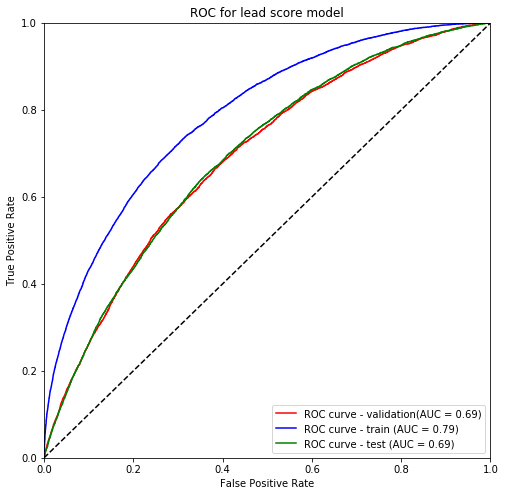

In [158]:
draw_ROC(gbm, dtrain, dvalid, dtest, y_train, y_valid, y_test)
plt.savefig('roc_xgb_first_train.png')
plt.show()

不调参的话交叉验证AUC均值如图，算是一个不错的模型，那么如果用bayes调参结果会怎么样呢？↓


### Distribution of predicted values

In [143]:
y_pred = gbm.predict(dtest) # gbm: gradient boosting machine

In [144]:
print (y_pred.max(), y_pred.min(), y_pred.mean())

# 就算是你觉得好到板上钉钉的贷款， 它的风险率是0.9%；很不好的贷款，它的风险率是76.3%

0.7259395 0.0065694503 0.1352567


### Feature importance

In [145]:
# xgboost的sklearn包没有feature_importance这个量度，但是get_fscore()函数有相同的功能
importance = gbm.get_fscore()
importance

{'grade': 48,
 'subgrade': 134,
 'dti': 416,
 'mosinoldilacct': 315,
 'annualinc': 331,
 'accopenpast24mths': 220,
 'emplength': 161,
 'numbctl': 102,
 'numactvbctl': 61,
 'mthssincelastdelinq': 215,
 'installment': 347,
 'totalrevhilim': 203,
 'mthssincelastmajorderog': 133,
 'mthssincerecentbc': 282,
 'mortacc': 68,
 'avgcurbal': 234,
 'mosinrcnttl': 135,
 'zipcode_freq': 222,
 'totcollamt': 88,
 'emptitle_freq': 279,
 'bcopentobuy': 264,
 'totalbclimit': 256,
 'verificationstatus_Not Verified': 14,
 'homeownership_RENT': 41,
 'mthssincerecentinq': 192,
 'intrate': 233,
 'numrevtlbalgt0': 60,
 'mthssincerecentrevoldelinq': 136,
 'totalacc': 125,
 'numsats': 90,
 'revolutil': 247,
 'addrstate_freq': 157,
 'mosinoldrevtlop': 288,
 'pcttlnvrdlq': 152,
 'earliestcrline_month': 273,
 'mosinrcntrevtlop': 123,
 'mthssincerecentbcdlq': 148,
 'numtloppast12m': 94,
 'percentbcgt75': 142,
 'numoprevtl': 73,
 'mthssincelastrecord': 178,
 'totalbalexmort': 201,
 'homeownership_MORTGAGE': 18,
 'zi

In [147]:
# F-score = ( 2 * precision*recall) /(precision + recall)

df_importance = pd.DataFrame.from_dict(importance,orient='index').reset_index()
df_importance.rename({0:'fscore','index':'feature'},axis=1,inplace=True)
df_importance['fscore'] = df_importance['fscore'] / df_importance['fscore'].sum()

df_importance.head(10)

,feature,fscore
2,dti,0.042440
10,installment,0.035401
4,annualinc,0.033769
3,mosinoldilacct,0.032136
32,mosinoldrevtlop,0.029382
13,mthssincerecentbc,0.028770
19,emptitle_freq,0.028464
52,tothicredlim,0.028055
34,earliestcrline_month,0.027851
20,bcopentobuy,0.026933


<Figure size 2304x2304 with 0 Axes>

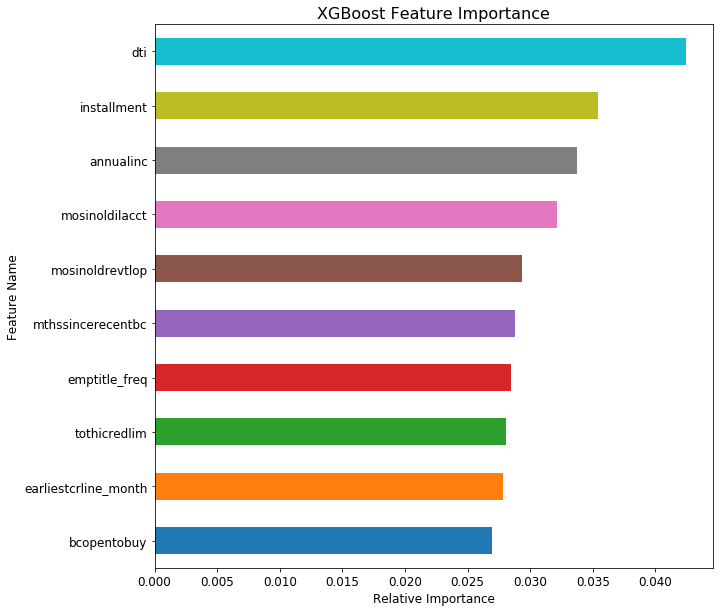

In [176]:
plt.figure(figsize=(32, 32))

df_importance[:10].sort_values(by='fscore').plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 10))
plt.tick_params(labelsize = 12)
plt.xlabel('Relative Importance', fontsize = 12)
plt.ylabel('Feature Name', fontsize = 12)

plt.title('XGBoost Feature Importance',fontsize = 16)
plt.gcf().savefig('feature_importance_xgb.png')

In [149]:
grade_importance = df_importance.query("feature=='grade'")
grade_importance

,feature,fscore
0,grade,0.004897


In [150]:
subgrade_importance = df_importance.query("feature=='subgrade'")
subgrade_importance

,feature,fscore
1,subgrade,0.013671


In [151]:
intrate_importance = df_importance.query("feature=='intrate'")
intrate_importance

,feature,fscore
25,intrate,0.023771


In [152]:
df_importance.query("feature=='loanamnt'")

,feature,fscore
46,loanamnt,0.017037


Text(0.5,0,'relative importance')

<Figure size 2304x2304 with 0 Axes>

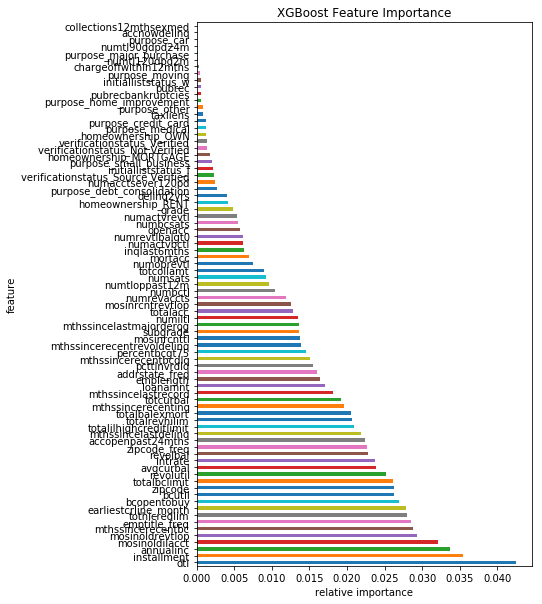

In [153]:
plt.figure(figsize=(32, 32))
# df_importance.plot()
df_importance.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

## Model Tuning
### Hyperparameter Tuning - Bayesian Optimization
grid search / bayes

In [154]:
from bayes_opt import BayesianOptimization

train_x = df_train[feat]
train_y = df_train.loanstatus

xgtrain = xgb.DMatrix(train_x, label=train_y, missing = np.NAN)  

# step1- 定义一个目标函数，里面放入我们希望优化的函数
def xgb_evaluate(min_child_weight,
                 colsample_bytree,
                 max_depth,
                 subsample,
                 gamma):
    params = dict()
    params['objective'] = 'binary:logistic'
    params['eta'] = 0.05
    params['max_depth'] = int(max_depth )   
    params['min_child_weight'] = int(min_child_weight)
    params['colsample_bytree'] = colsample_bytree
    params['subsample'] = subsample
    params['gamma'] = gamma
    params['verbose_eval'] = False 


    #xgb.cv交叉验证
    cv_result = xgb.cv(params, #超参数
                       xgtrain, #训练集
                       num_boost_round=100000,
                       nfold=3, 
                       metrics={'auc'},
                       seed=1234,
                       callbacks=[xgb.callback.early_stop(50)])
    print(cv_result)
    # 为了实现提前停止的交叉验证，我们使用xgboost函数cv，它输入为超参数，训练集，用于交叉验证的折数等
    # 将迭代次数num_boost_round设为10000，但实际不会达到这个数字，因为我们用early_stop停止训练，当50轮迭代后都没有提升时，
# 则提前停止并选择模型，因此，迭代次数并不是我们需要设置的超参数。

    # 一旦交叉验证完成，我们就会得到最好的分数roc-auc,然后返回这个值↓
    return cv_result['test-auc-mean'].max()



# bayes优化对象:第一个参数是优化目标函数，第二个参数是所需要输入的超参数名称和其范围。超参数名称必须和目标函数的输入名称一一对应
xgb_BO = BayesianOptimization(xgb_evaluate, 
                             {'max_depth': (4, 8),
                              'min_child_weight': (0, 20),
                              'colsample_bytree': (0.2, 0.8),
                              'subsample': (0.5, 1),
                              'gamma': (0, 2)
                             })


In [ ]:
# step2- 运行bayes优化, 设置初始点的数量，以及我们想要的迭代次数，迭代次数将是我们要训练的机器学习模型数量

    
xgb_BO.maximize(init_points=5, n_iter=40, acq='ei', xi=0.0)
    
#xgb_BO.maximize(init_points=5, n_iter=40)

In [156]:
## step3- Tuning results 等到程序结束，我们可以查看当前最优的参数和结果：
xgb_BO.max

{'target': 0.6899243333333334,
 'params': {'colsample_bytree': 0.32221742682392707,
  'gamma': 1.888745445753438,
  'max_depth': 4.036348790067709,
  'min_child_weight': 19.984365517870163,
  'subsample': 0.7112055441024843}}

In [159]:
xgb_BO.res

[{'target': 0.6887366666666667,
  'params': {'colsample_bytree': 0.5812329423129357,
   'gamma': 0.8678977507427901,
   'max_depth': 4.059622043705835,
   'min_child_weight': 12.946454840212505,
   'subsample': 0.7945144198585279}},
 {'target': 0.6895579999999999,
  'params': {'colsample_bytree': 0.43689187355135795,
   'gamma': 0.1386007236314446,
   'max_depth': 4.280480926952631,
   'min_child_weight': 5.257042363761015,
   'subsample': 0.6862056484853174}},
 {'target': 0.6883256666666666,
  'params': {'colsample_bytree': 0.6166865884032364,
   'gamma': 0.4465144971951205,
   'max_depth': 6.198954751606491,
   'min_child_weight': 15.949471904218612,
   'subsample': 0.6931612816833945}},
 {'target': 0.6899066666666668,
  'params': {'colsample_bytree': 0.44366857555262706,
   'gamma': 1.1853924774703042,
   'max_depth': 4.029663085342705,
   'min_child_weight': 16.065623526959588,
   'subsample': 0.5817640254624865}},
 {'target': 0.6877393333333334,
  'params': {'colsample_bytree': 0.

In [160]:
a = [{**x, **x.pop('params')} for x in xgb_BO.res]
xgb_BO_scores = pd.DataFrame(a)
print(xgb_BO_scores.head(10))

xgb_BO_max = pd.DataFrame(xgb_BO.max).T
xgb_BO_max

   colsample_bytree     gamma  max_depth  min_child_weight  subsample  \
0          0.581233  0.867898   4.059622         12.946455   0.794514   
1          0.436892  0.138601   4.280481          5.257042   0.686206   
2          0.616687  0.446514   6.198955         15.949472   0.693161   
3          0.443669  1.185392   4.029663         16.065624   0.581764   
4          0.670103  1.196629   7.914835         14.904392   0.824585   
5          0.228359  1.675747   4.223652          0.043522   0.956570   
6          0.298586  0.054941   4.066673          0.021437   0.934564   
7          0.314169  1.643183   7.991643          0.055723   0.634114   
8          0.502175  1.333172   4.258467         19.993869   0.836213   
9          0.677247  1.479987   4.113129         19.980955   0.532921   

     target  
0  0.688737  
1  0.689558  
2  0.688326  
3  0.689907  
4  0.687739  
5  0.689266  
6  0.688501  
7  0.687002  
8  0.688998  
9  0.688868  


,colsample_bytree,gamma,max_depth,min_child_weight,subsample
target,0.689924,0.689924,0.689924,0.689924,0.689924
params,0.322217,1.888745,4.036349,19.984366,0.711206


In [106]:
## Tuning results
#xgb_BO_scores = pd.DataFrame(xgb_BO.res['all']['params'])
#xgb_BO_scores['score'] = pd.DataFrame(xgb_BO.res['all']['values'])
#xgb_BO_scores = xgb_BO_scores.sort_values(by='score',ascending=False)
#xgb_BO_scores.head(3)

### Retrain model with tuned parameters

In [162]:
params = xgb_BO_max.iloc[1].to_dict()
params

{'colsample_bytree': 0.32221742682392707,
 'gamma': 1.888745445753438,
 'max_depth': 4.036348790067709,
 'min_child_weight': 19.984365517870163,
 'subsample': 0.7112055441024843}

In [163]:
# xgboost.train()利用param列表设置模型参数
# xgboost.XGBClassifier()利用函数参数设置模型参数。 用途是一样的

best_xgb_iteration = 1500 # 前面num_boost_round = 1500

clf_train = xgb.XGBClassifier(learning_rate = 0.01
                  , n_estimators = best_xgb_iteration
                  , max_depth = int(params['max_depth']) 
                  , min_child_weight = params['min_child_weight']
                  , subsample = params['subsample']
                  , colsample_bytree = params['colsample_bytree']
                  , gamma = params['gamma']
                  , seed = 1441
                  , nthread = -1
                  , scale_pos_weight = 1
                  , eval_metric= 'auc'
                            
                  )


xgboost.train()利用param列表设置模型参数 <br>
xgboost.XGBClassifier()利用函数参数设置模型参数。 用途是一样的 <br>


https://www.cnblogs.com/Allen-rg/p/10563362.html <br>

gbm = **xgb.train(**
- params = {‘booster’:’gbtree’,’eta’:0.1}， 这是一个字典，里面包含着训练中的参数关键字和对应的值
- dtrain： 训练的数据
- obj：   自定义目的函数
- feval：  自定义评估函数

- evals： 这是一个列表，用于对训练过程中进行评估列表中的元素。形式是evals = $[$(dtrain,’train’),(dval,’val’)$]$ 
或者是evals = $[$(dtrain,’train’)$]$。对于第一种情况,它使得我们可以在训练过程中观察验证集的效果
- evals_result： 字典，存储在watchlist中的元素的评估结果。
- early_stopping_rounds：当设置的迭代次数较大时，可在一定的迭代次数内准确率没有提升就停止训练。
要求evals里至少有一个元素,如果有多个,按最后一个去执行,返回的是最后的迭代次数（不是最好的），
如果early_stopping_rounds存在，则模型会生成三个属性： 
bst.best_score，bst.best_iteration，bst.best_ntree_limit 
- verbose_eval： (可以输入布尔型或数值型)，也要求evals里至少有一个元素, 
如果为True,则对evals中元素的评估结果会输出在结果中；如果输入数字5，则每隔5个迭代输出一次
- xgb_model： 在训练之前用于加载的xgb model



clf = **XGBClassifier(**
- silent =0 ： 设置成1则没有运行信息输出，最好是设置为0.是否在运行升级时打印消息。
- nthread =4： cpu 线程数 默认最大
- learning_rate = 0.3：   如同学习率
- min_child_weight =1,   这个参数默认是1，是每个叶子里面 h 的和至少是多少，
对正负样本不均衡时的0-1分类而言, 假设 h 在0.01附近，min_child_weight 为1意味着叶子节点中最少需要包含100个样本，
这个参数非常影响结果，控制叶子节点中二阶导的和的最小值，该参数值越小，越容易overfitting
- max_depth =6：  构建树的深度，越大越容易overfitting
- gamma =0：    树的叶子节点上作进一步分区所需的最小损失减少,越大越保守，一般0.1、0.2这样子。
- subsample =1：  随机采样训练样本， 训练实例的子采样比
- max_delta_step =0： 最大增量步长，我们允许每个树的权重估计。
- colsample_bytree =1：  生成树时进行的列采样 
- reg_lambda =1：    控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易overfitting
- reg_alpha =0：    L1 正则项参数
- scale_pos_weight =1；   如果取值大于0的话，在类别样本不平衡的情况下有助于快速收敛,平衡正负权重
- objective = 'multi:softmax'：     多分类的问题 指定学习任务和相应的学习目标
- num_class =10：       类别数，多分类与multisoftmax并用
- n_estimators =100：   树的个数
- seed =1000：  随机种子
- eval_metric = 'auc'

In [ ]:
params = {"objective": "binary:logistic", 
          "booster" : "gbtree", 
          "eta": 0.01, 
          "max_depth": 4, 
          "subsample": 0.5115777, 
          "colsample_bytree":  0.509529,
          "min_child_weight": 13.93988,
          "gamma":  0.335555,
          "silent": 1, 
          "seed": 1441, 
          "eval_metric": "auc"
          } 

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
num_boost_round = 1500

gbm2 = xgb.train(params, 
                dtrain, 
                num_boost_round, 
                evals = watchlist,
                early_stopping_rounds = 50)


## Model Evaluation

### Feature Importance
The importance of features is generated based on the feature importance scores from the XGBoost model.<br> 
From the result below it is found that the top 10 important features include Debt to Income Ratio,Installment, Annual Income, Interest Rate,Number of trades in past 24 months and so on. 

In [168]:
importance2 = gbm2.get_fscore()

In [169]:
df_importance2 = pd.DataFrame.from_dict(importance2,orient='index').reset_index()
df_importance2.rename({0:'fscore','index':'feature'},axis=1,inplace=True)
df_importance2['fscore'] = df_importance2['fscore'] / df_importance2['fscore'].sum()
df_importance2.sort_values(['fscore'], ascending=False, inplace=True)

df_importance2.head(10)


,feature,fscore
2,dti,0.048217
7,installment,0.041913
13,annualinc,0.039414
20,intrate,0.031747
5,accopenpast24mths,0.031690
22,mosinoldrevtlop,0.030441
55,zipcode,0.028396
46,mosinoldilacct,0.027658
1,subgrade,0.026636
11,avgcurbal,0.026408


<Figure size 2304x2304 with 0 Axes>

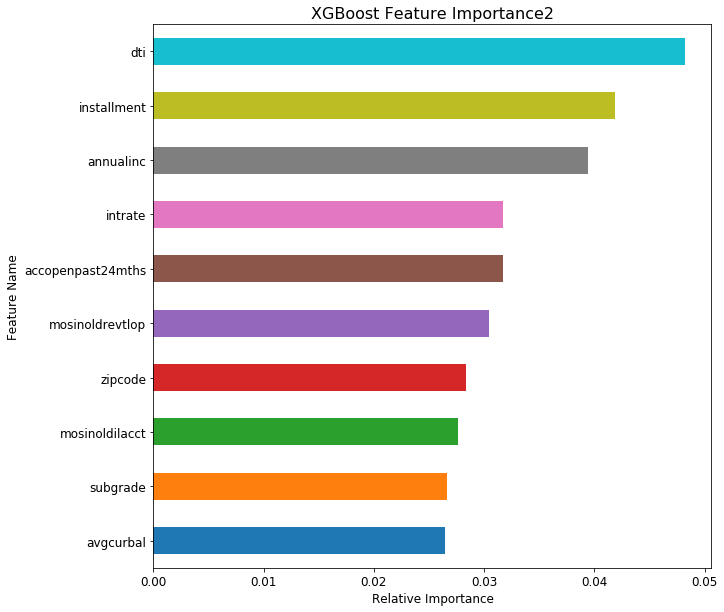

In [175]:
plt.figure(figsize=(32, 32))

df_importance2[:10].sort_values(by='fscore').plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 10))
plt.tick_params(labelsize = 12)
plt.xlabel('Relative Importance', fontsize = 12)
plt.ylabel('Feature Name', fontsize = 12)

plt.title('XGBoost Feature Importance2',fontsize = 16)
plt.gcf().savefig('feature_importance2_xgb2.png')

### Validate on test data
The tuned model is used to predict the default rates in the testing dateset. The predicted default rate on the test set is about 0.1355, very close to the average default rate of around 0.1373. <br>
The result of model performance is visualized via the ROC curve. The AUC scores on the training and validation sets are about 0.70 and 0.74, and the AUC score on the testing set is about 0.70.

In [201]:
y_pred = gbm2.predict(dtest)
print (y_pred.max(), y_pred.min(), y_pred.mean())

print(df.loanstatus.mean())

0.6602236 0.009783567 0.13554929
0.13726394783785445


### ROC Curve


Area under the ROC curve - validation: 0.695323
Area under the ROC curve - train: 0.736148
Area under the ROC curve - test: 0.698004


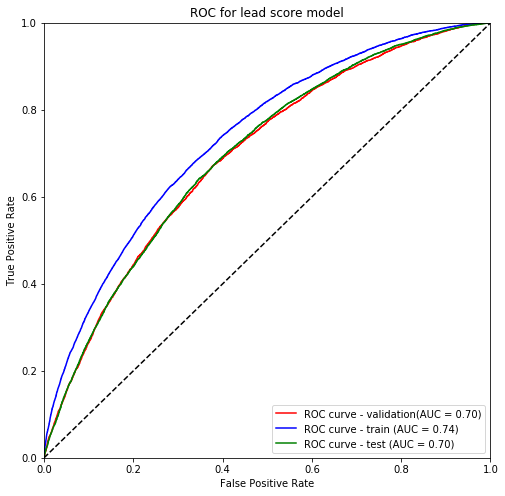

In [183]:
idx_0, thresholds_0, idx_1, thresholds_1, idx_2, thresholds_2 = \
draw_ROC(gbm2, dtrain, dvalid, dtest, y_train, y_valid, y_test)

plt.savefig('roc_xgb_retrain_autotuned.png')
plt.show()

### Thresholds
The best threshold of predicting default is determined based on Index value(= tpr - fpr), which optimizes the sensitivity and specificity.<br> 
From the figure below, 'TPR-FPR' maximizes at a threshold of 0.15. The maximum f1-score at the threshold of 0.15 is 0.34876, with a recall rate of 0.62, suggesting that 62% of total defalut loans is correctly classified by the model.

validation: (0.13546135, 0.29358952953102174)
train: (0.14353114, 0.34313703110251664)
test: (0.14510967, 0.2947599826424135)


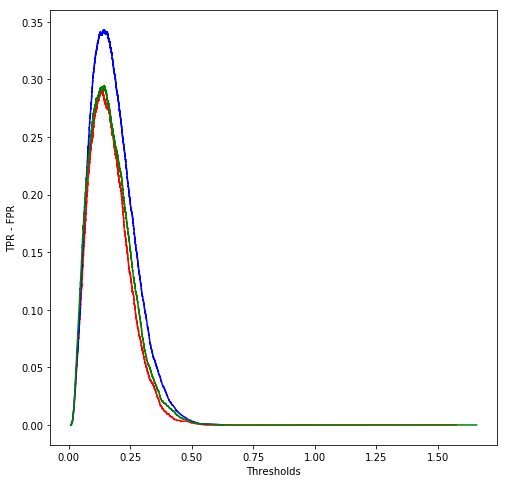

In [199]:
plt.figure(figsize = (8,8))
plt.plot(thresholds_0, idx_0, label = "ROC curve - validation", color= 'r')
plt.plot(thresholds_1, idx_1, label = "ROC curve - train", color= 'b')
plt.plot(thresholds_2, idx_2, label = "ROC curve - test", color= 'g')
plt.xlabel('Thresholds')
plt.ylabel("TPR - FPR")

def max_threshold( x_feature, y_feature):
    y_max = max(y_feature)
    x_max = x_feature[ y_feature.argmax()] # Find the x value corresponding to the max y value
    return(x_max, y_max )

print ('validation:',max_threshold(thresholds_0, idx_0))
print ('train:',max_threshold(thresholds_1, idx_1))
print ('test:',max_threshold(thresholds_2, idx_2))

In [200]:
from sklearn.metrics import precision_recall_fscore_support

for thrd in [0, 0.1, 0.14, 0.15, 0.2, 0.25, 0.5]:
    test_results = []
    for prob in y_pred:
        if prob > thrd:
            test_results.append(1)
        else:
            test_results.append(0)
    print ("threshold:", thrd, precision_recall_fscore_support(y_test, test_results, pos_label=1, average='binary'))

# precision_recall_fscore_support 计算precision、recall、f-score(前两者的调和平均数)、支持率
 # https://www.cnblogs.com/cnkai/p/7755141.html


threshold: 0 (0.14528188724510196, 1.0, 0.25370502906418557, None)
threshold: 0.1 (0.20238544058676355, 0.8125774047062061, 0.32405882998573154, None)
threshold: 0.14 (0.23337564690948148, 0.6577679922939315, 0.34451691952863167, None)
threshold: 0.15 (0.2425497579343733, 0.6204761249483969, 0.34876435781413156, None)
threshold: 0.2 (0.2801012753188297, 0.41103619100041283, 0.33316602531927947, None)
threshold: 0.25 (0.3203311867525299, 0.23957616623090683, 0.274130058258542, None)
threshold: 0.5 (0.5217391304347826, 0.003302600798128526, 0.006563653767263777, None)


## Save model

In [ ]:
import pickle

In [ ]:
with open('model.pkl','wb') as pkl_file:
    pickle.dump(gbm, pkl_file)

In [ ]:
from sklearn.externals import joblib
joblib.dump(gbm, "pima.joblib.dat")